<a href="https://colab.research.google.com/github/Teasotea/Age-Rate-Classifier-NLP/blob/main/Kaggle_huge_dataset_other_features_dense_age_rate_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dense Age Rate Classifier



###TODO: Build a dense neural net to classify  movies by their age rate.

In [4]:
pip install geotext


     |████████████████████████████████| 2.0 MB 7.8 MB/s 


In [5]:
! pip install kaggle

In [12]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
import os
import io
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import names
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
from geotext import GeoText
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


#Old Data

In [276]:
dataset_url = 'https://raw.githubusercontent.com/Teasotea/Age-Rate-Classifier-NLP/main/IMDB_data.csv'
df = pd.read_csv(dataset_url)
df.head()

,Unnamed: 0,Name of movie,Description,Age rate,Year,Runtime,Genre
0,0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,R,1994,142,Drama
1,1,The Godfather,The Godfather follows Vito Corleone Don of the...,R,1972,175,"Crime, Drama"
2,2,Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst...",R,1994,154,"Crime, Drama"
3,3,The Godfather: Part II,The early life and career of Vito Corleone in ...,R,1974,202,"Crime, Drama"
4,4,Inception,A thief who steals corporate secrets through t...,PG-13,2010,148,"Action, Adventure, Sci-Fi"


In [ ]:
# is_r = list()
# for i in df['Age rate']:
#   if i=='R': is_r.append(1)
#   else: is_r.append(0)
# print(is_r.count(0), ":", is_r.count(1))

447 : 338


#Load data from Kaggle

In [209]:
#1
! kaggle datasets download lukelarue/movie-attributes-for-3400-movies-from-20002020
! unzip movie-attributes-for-3400-movies-from-20002020.zip


movie-attributes-for-3400-movies-from-20002020.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  movie-attributes-for-3400-movies-from-20002020.zip
replace Attributes_DataFrame.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [120]:
#2
! kaggle datasets download igorkirko/wwwboxofficemojocom-movies-with-budget-listed --force
! unzip wwwboxofficemojocom-movies-with-budget-listed.zip

  0% 0.00/841k [00:00<?, ?B/s]
100% 841k/841k [00:00<00:00, 29.0MB/s]
Archive:  wwwboxofficemojocom-movies-with-budget-listed.zip
  inflating: Mojo_budget_data.csv    
  inflating: Mojo_budget_update.csv  


In [342]:
#3
! kaggle datasets download igorkirko/imdb-summary-trivia
! unzip imdb-summary-trivia.zip

 76% 25.0M/32.8M [00:00<00:00, 37.3MB/s]
100% 32.8M/32.8M [00:00<00:00, 60.7MB/s]
Archive:  imdb-summary-trivia.zip
  inflating: imdb_data_update.csv    


In [210]:
kaggle_df = pd.read_csv("Attributes_DataFrame.csv")
k_dataset = kaggle_df.drop(['Domestic','International', 'Budget', 'Runtime'], axis=1)
k_dataset.head()

,Title,Distributor,MPAA-Rating,Genres
0,Jurassic World (2015),Universal Pictures,PG-13,Action;Adventure;Sci-Fi
1,Star Wars: Episode VII - The Force Awakens (2015),Walt Disney Studios Motion Pictures,PG-13,Action;Adventure;Sci-Fi
2,Avengers: Age of Ultron (2015),Walt Disney Studios Motion Pictures,PG-13,Action;Adventure;Sci-Fi
3,Inside Out (2015),Walt Disney Studios Motion Pictures,PG,Adventure;Animation;Comedy;Drama;Family;Fantasy
4,Furious 7 (2015),Universal Pictures,PG-13,Action;Adventure;Thriller


In [211]:
kaggle_df2 = pd.read_csv("Mojo_budget_data.csv")
k_dataset2 = kaggle_df2.drop(['movie_id', 'movie_year', 'director', 'writer','producer', 'composer','cinematographer', 
'main_actor_1', 'main_actor_2', 'main_actor_3', 'main_actor_4', 'budget', 'domestic', 'international',
'worldwide', 'link', 'run_time'],axis=1).fillna('')
k_dataset2 = k_dataset2.set_index("mpaa")
k_dataset2 = k_dataset2.drop('').reset_index()
k_dataset2.head() 

,mpaa,movie_title,genre_1,genre_2,genre_3,genre_4
0,PG-13,Glitter,Drama,Music,Romance,
1,PG-13,Fantastic Four,Action,Adventure,Family,Fantasy
2,R,Frida,Biography,Drama,Romance,
3,R,From Hell,Horror,Mystery,Thriller,
4,PG-13,The Lord of the Rings: The Fellowship of the Ring,Action,Adventure,Drama,Fantasy


In [357]:
kaggle_df3 = pd.read_csv("imdb_data_update.csv")
k_dataset3 = kaggle_df3.drop(['year','run_time','rating','ratings_count','budget','director', 'world_gross',
                              'actor','writer'],axis=1).fillna('')
for i in range(len(k_dataset3)):
  if k_dataset3['synopsis'][i].startswith('It looks like'):
    k_dataset3['synopsis'][i] = ''
k_dataset3 = k_dataset3.set_index("mpaa")
k_dataset3 = k_dataset3.drop('').reset_index()
k_dataset3.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,mpaa,title,genre,keywords,summary,synopsis
0,PG-13,Kate & Leopold,"['Comedy', 'Fantasy', 'Romance']","['time travel', 'brooklyn bridge', 'bridge', '...",An English Duke from 1876 is inadvertedly drag...,"In 1876, Leopold Alexis Elijah Walker Gareth T..."
1,R,The Other Side of the Wind,['Drama'],"['film business', 'nudity', 'female nudity', '...",A Hollywood director emerges from semi-exile w...,
2,PG,Me and the Kid,"['Comedy', 'Crime', 'Drama', 'Family']","['kidnapper kidnapped relationship', 'family r...",A lonely and emotionally neglected rich kid fo...,
3,R,Sexpot,['Comedy'],"['promiscuous wife', 'floozy', 'jug', 'widow',...","A woman marries wealthy men, then arranges for...",
4,R,"Any Time, Any Play","['Crime', 'Drama']","['mobster', 'sexploitation', 'hot', 'erotic cr...",When her ex-lover takes a job at her club as a...,


In [239]:
is_r = list()
for i in k_dataset['MPAA-Rating']:
  if i=='R': is_r.append(1)
  else: is_r.append(0)
print(is_r.count(0), ":", is_r.count(1))

2159 : 1241


In [240]:
is_r2 = list()
for i in k_dataset2['mpaa']:
  if i=='R': is_r2.append(1)
  else: is_r2.append(0)
print(is_r2.count(0), ":", is_r2.count(1))


1440 : 974


In [358]:
is_r3 = list()
for i in k_dataset3['mpaa']:
  if i=='R': is_r3.append(1)
  else: is_r3.append(0)
print(is_r3.count(0), ":", is_r3.count(1))

5276 : 9599


In [360]:
is_r.extend(is_r2)
is_r.extend(is_r3)
print(is_r.count(0), ":", is_r.count(1))

10315 : 12788


#Data processing

In [474]:
data = [''.join([i for i in n.lower() if not i.isdigit()]).replace('(', '').replace(')', '')[:-1] 
for n in k_dataset['Title']] 
data += [n.lower() for n in k_dataset2['movie_title']]
data += [n.lower() for n in k_dataset3['title']]

for i in range(len(k_dataset)):
  data[i] += " " + str(k_dataset['Distributor'][i]).lower()
for i in range(len(k_dataset3)):
  data[i+len(k_dataset)+len(k_dataset2)] += " " + str(k_dataset3['summary'][i])
  data[i+len(k_dataset)+len(k_dataset2)] += " " + str(k_dataset3['synopsis'][i])
data2 = []

#define stopwords
numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 	'thirteen', 'fourteen', 'fifteen', 
'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 'hundred']
stpwrds = stopwords.words('english') + [i.lower() for i in names.words('male.txt') + names.words('female.txt')] + numbers

# remove city names from name
for i in range(len(data)):
  places = GeoText(data[i])
  if places.cities != []:
    for j in places.cities:
      data[i] = data[i].replace(j.lower(), '').lower()

for i in data:
  #remove punctuation and split
  tr= str.maketrans(dict.fromkeys(string.punctuation))
  new_i = i.translate(tr)
  descr = list(set(new_i.split(sep=' ')))
  #remove stop words or numbers
  for k in range(1):
    for j in descr:
      if j in stpwrds:
        descr.remove(j)
      if j!= '' and j[0].isdigit():
        descr.remove(j)
    if "" in descr:
      descr.remove("")
  data2.append(descr)

In [479]:
print(k_dataset3['title'][15348-len(k_dataset['Title'])-len(k_dataset2['movie_title'])])
print(k_dataset3['summary'][15348-len(k_dataset['Title'])-len(k_dataset2['movie_title'])])
print(k_dataset3['synopsis'][15348-len(k_dataset['Title'])-len(k_dataset2['movie_title'])])
print(data2[15348])
print(data2[15348].count('and'))
print(len(data2))

Me and Orson Welles
In 1937, a teenager is cast in the Mercury Theatre production of "Julius Caesar", directed by a youngOrson Welles.
New York, 1937: RICHARD SAMUELS (17) is bored with school and dreams of treading the boards on Broadway. After a chance encounter with a theatre company outside a derelict theatre, The Mercury, Richard soon finds himself inside chatting with Orson Welles, the Director of Broadways first Shakespearean production, Julius Caesar. Welles is a bullish, competitive character who is having an affair with the leading lady, MURIEL BRASSLER, despite his wife VIRGINIAS pregnancy. Richard plays on Welles egotistical nature and manages to bluff his way into the role of Lucius; Welles swiftly couples him with the gorgeous production assistant SONJA JONES (20), to rehearse. Richard, along with the rest of the crew, is captivated by Sonjas vivacity and ability to manage everything behind the scenes by schmoozing all the right people. It soon becomes apparent that she i

#Add more features

In [476]:
for i in range(len(k_dataset)):
  data2[i].extend(str(k_dataset['Genres'][i]).replace(';', ' ').lower().split(' '))
for i in range(len(k_dataset2)):
  data2[i+len(k_dataset['Title'])].append(str(k_dataset2['genre_1'][i]).lower())
  data2[i+len(k_dataset['Title'])].append(str(k_dataset2['genre_2'][i]).lower())
  data2[i+len(k_dataset['Title'])].append(str(k_dataset2['genre_3'][i]).lower())
  data2[i+len(k_dataset['Title'])].append(str(k_dataset2['genre_4'][i]).lower())
  if '' in data2[i+len(k_dataset['Title'])]:
    data2[i+len(k_dataset['Title'])].remove('')
for i in range(len(k_dataset3)):
  data2[i+len(k_dataset['Title'])+len(k_dataset2['movie_title'])].extend(k_dataset3['genre'][i].replace('[', '').replace(']', '').replace('\'', '').replace(',', '').lower().split(' '))
  data2[i+len(k_dataset['Title'])+len(k_dataset2['movie_title'])].extend(k_dataset3['keywords'][i].replace('[', '').replace(']', '').replace('\'', '').replace(',', '').lower().split(' '))
  if '' in data2[i+len(k_dataset['Title'])+len(k_dataset2['movie_title'])]:
    data2[i+len(k_dataset['Title'])+len(k_dataset2['movie_title'])].remove('')
print(data2[2+len(k_dataset['Title'])+len(k_dataset2['movie_title'])])

['lonely', 'and', 'forms', 'men', 'kid', 'A', 'emotionally', 'attachment', 'neglected', 'robbery', 'botched', 'who', 'fathers', 'kidnap', 'safe', 'him', 'an', 'comedy', 'crime', 'drama', 'family', 'kidnapper', 'kidnapped', 'relationship', 'family', 'relationships', 'brooklyn', 'bridge', 'puppy', 'police']


#Stem words

In [477]:
stemmer = PorterStemmer()
for i in range(len(data2)):
  data2[i] = [stemmer.stem(w.lower()) for w in data2[i]]
print(data2[15348])

['anyth', 'director', 'concern', 'actor', 'by', 'scene', 'pair', 'instead', 'tell', 'appar', 'women', 'affair', 'despit', 'express', 'apolog', 'open', 'tread', 'injuri', 'when', 'with', 'mere', 'date', 'gone', 'distraught', 'success', 'secur', 'wait', 'increasingli', 'teenag', 'goe', 'get', 'off', 'board', 'selznik', 'play', 'egotist', 'lack', 'assist', 'young', 'drink', 'busi', 'pair', 'introduc', 'success', 'everyth', 'day', 'normal', 'rehears', 'becom', 'break', 'well', 'learn', 'declar', 'shakespearean', 'jone', 'rest', 'intent', 'return', 'add', 'famili', 'well', 'is', 'follow', 'selznick', 'total', 'apologis', 'theatr', 'lead', 'derelict', 'samuel', 'product', 'virginia', 'bluff', 'teambuild', 'big', 'career', 'role', 'coupl', '20', 'crew', 'wildli', 'all', 'mercuri', 'manag', 'gorgeou', 'richard', 'decid', 'note', 'school', 'return', 'chat', 'compani', 'hard', 'pick', 'cheat', 'peopl', 'agre', 'see', 'richard', 'encount', 'youngorson', 'will', 'geniu', 'argument', 'cast', 'promi

#Combine it in final dataset

In [480]:
short_df = pd.DataFrame(list(zip(data2, is_r)),
               columns =['info', 'age rate'])

short_df.tail()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(short_df)

,info,age rate
20684,"[sylvi, player, at, aspir, late, a, harlem, sa...",1
20685,"[fire, look, arent, were, distract, develop, d...",0
20686,"[local, is, summary», tilleri, task, want, wat...",1
20687,"[earn, unlik, dream, welsh, he, her, convinc, ...",1
20688,"[at, as, christian, faith, distant, challeng, ...",1


In [481]:
short_df.iloc[20000:20020].head()

,info,age rate
20000,"[panama, pair, laundromat, partner, exploit, l...",1
20001,"[heart, ring, into, dogfight, belong, us, inju...",0
20002,"[alabast, affluent, penelop, it, wild, samuel,...",0
20003,"[cope, is, episod, a, schizophrenia, releas, o...",1
20004,"[rap, outrag, bodi, battl, subject, when, a, g...",0


# Hyperparameters


In [395]:
# output directory name:
output_dir = 'model_output/dense'

embedding_dim = 64
max_features=10000
maxlen=150

####
# training:
epochs = 6#4
batch_size = 32#784

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
#n_words_to_skip = 50 # ditto
max_decription_length = 100 #max_review_length (amount of tokens(words))
pad_type = trunc_type = 'pre' #could be 'post'

# neural network architecture: 
n_dense = 64 #neurons
dropout = 0.5 #drop 50% of neurons 





# Tokenizer

In [482]:
#tokenizer of descriptions
t  = Tokenizer(num_words=max_features)
t.fit_on_texts([x for x in short_df['info']])
print(len(t.word_index))
os.makedirs(output_dir, exist_ok=True)
with io.open(output_dir+'/tokenizer.json', 'w',encoding='utf-8', ) as f:
    f.write(json.dumps(t.to_json(),ensure_ascii=False))
vocab_size = len(t.word_index) + 1
num_categories = 1


112403


In [483]:
info_sequences = t.texts_to_sequences([x for x in np.array(short_df['info'])])
info_sequences = tf.keras.preprocessing.sequence.pad_sequences(info_sequences, maxlen=maxlen)
print(info_sequences[0])
print('sequences : ',info_sequences,'\n')
print('word_index : ',t.word_index)
print(np.array(info_sequences))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  134  603  135 8730   13   56  176]
sequences :  [[   0    0    0 ...   13   56  176]
 [   0    0    0 ...   13   56  176]
 [   0    0    0 ...   13   56  176]
 ...
 [   0    0    0 ...  976 3268 4269]
 [   0    0    0 ...  226  378   93]
 [   0    0    0 ... 1132 1856   49

#Split data into train and test 

In [249]:
X_train, X_test, y_train, y_test = train_test_split(info_sequences, short_df['age rate'], test_size=0.1, random_state=42)


print(np.array(X_train))

[[ 0  0  0 ... 13 12  4]
 [ 0  0  0 ...  8 14  4]
 [ 0  0  0 ... 62 63  2]
 ...
 [ 0  0  0 ...  8 13  4]
 [ 0  0  0 ...  2 10  9]
 [ 0  0  0 ...  6  2  7]]


In [250]:
l = len(X_train[363])
print(l)

20


# Model and Train

In [251]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2000,activation='relu'),
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(num_categories, activation=tf.nn.sigmoid)
])

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 64)            195200    
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 2000)              2562000   
                                                                 
 dense_13 (Dense)            (None, 500)               1000500   
                                                                 
 dense_14 (Dense)            (None, 100)               50100     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,807,901
Trainable params: 3,807,901
No

In [252]:
#embedding level
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [253]:
#flatten
max_decription_length, n_dim, n_dim*max_decription_length

(100, 64, 6400)

In [254]:
#dense
n_dense, n_dim*max_decription_length*n_dense+n_dense #weights + biases

(64, 409664)

In [255]:
#output
n_dense + 1

65

#Configure model

In [256]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
callbacks=[modelcheckpoint]



if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.fit(X_train.astype('float32'),
          np.array(y_train).astype('float32').reshape((-1,1)), 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(X_test.astype('float32'), 
          np.array(y_test).astype('float32').reshape((-1,1))), callbacks=callbacks)

Epoch 1/6
164/164 [==============================] - 12s 64ms/step - loss: 0.5422 - accuracy: 0.6929 - val_loss: 0.5185 - val_accuracy: 0.7354
Epoch 2/6
164/164 [==============================] - 10s 63ms/step - loss: 0.3769 - accuracy: 0.8280 - val_loss: 0.3634 - val_accuracy: 0.8419
Epoch 3/6
164/164 [==============================] - 10s 63ms/step - loss: 0.1821 - accuracy: 0.9268 - val_loss: 0.4170 - val_accuracy: 0.8179
Epoch 4/6
164/164 [==============================] - 10s 63ms/step - loss: 0.0957 - accuracy: 0.9618 - val_loss: 0.4801 - val_accuracy: 0.8316
Epoch 5/6
164/164 [==============================] - 11s 64ms/step - loss: 0.0644 - accuracy: 0.9719 - val_loss: 0.5690 - val_accuracy: 0.8265
Epoch 6/6
164/164 [==============================] - 11s 65ms/step - loss: 0.0509 - accuracy: 0.9786 - val_loss: 0.6902 - val_accuracy: 0.8402


In [257]:
score = model.evaluate(np.array(X_test), np.array(y_test)) 

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

19/19 [==============================] - 0s 9ms/step - loss: 0.6902 - accuracy: 0.8402
Test Score: 0.6902134418487549
Test Accuracy: 0.8402062058448792


# Accuracy

In [258]:
model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [259]:
y_hat = model.predict(X_test)

In [260]:
len(y_hat)

582

In [261]:
y_hat[3]

array([0.00024584], dtype=float32)

In [262]:
print(np.array(y_test)[3])

0


In [263]:
print(type(y_hat))

<class 'numpy.ndarray'>


In [264]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'91.50'

In [265]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [266]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(ydf)

        y_hat  y
0    0.771305  1
1    0.770226  1
2    0.000199  0
3    0.000246  0
4    0.000176  0
5    0.884231  1
6    0.504186  0
7    0.833341  1
8    0.210100  1
9    0.002688  0
10   0.231967  0
11   0.002677  0
12   0.255800  0
13   0.680396  1
14   0.000423  0
15   0.813631  1
16   0.223228  0
17   0.414290  0
18   0.125712  0
19   0.000124  0
20   0.129788  1
21   0.557719  0
22   0.745428  1
23   0.002250  0
24   0.013941  0
25   0.314848  1
26   0.181131  0
27   0.555818  1
28   0.385368  0
29   0.512749  0
30   0.034527  0
31   0.330670  0
32   0.607571  1
33   0.017965  0
34   0.915454  1
35   0.813048  1
36   0.255953  0
37   0.582758  1
38   0.031988  0
39   0.035200  0
40   0.254880  1
41   0.894640  1
42   0.776654  0
43   0.044443  0
44   0.153470  0
45   0.000681  0
46   0.968227  0
47   0.837228  0
48   0.662675  1
49   0.268900  0
50   0.744991  0
51   0.354468  0
52   0.000311  0
53   0.103217  0
54   0.782643  1
55   0.115416  0
56   0.002626  0
57   0.204502 

In [267]:
print(k_dataset.iloc[752])
print('Prediction:', y_hat[0])
print("Reality:", y_test.iloc[0])

Title                         Raising Helen (2004)
Distributor    Walt Disney Studios Motion Pictures
MPAA-Rating                                  PG-13
Genres                        Comedy;Drama;Romance
Name: 752, dtype: object
Prediction: [0.77130514]
Reality: 1


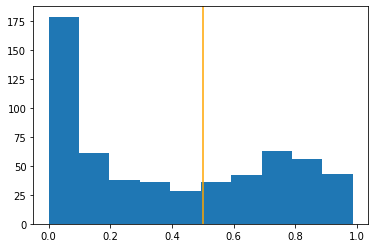

In [273]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [269]:
print(len(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)]))
print(len(y_test))

3
582


In [270]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y_test)

393     1
5091    1
2638    0
1002    0
168     0
5494    1
800     0
1732    1
4532    1
5381    0
1599    0
4037    0
2775    0
4398    1
3968    0
1032    1
5781    0
2705    0
4270    0
156     0
1717    1
1558    0
1393    1
1554    0
3250    0
4969    1
2623    0
4689    1
4985    0
1421    0
4594    0
1741    0
2118    1
2977    0
4454    1
4253    1
3258    0
5606    1
3135    0
1702    0
3276    1
1586    1
2859    0
3686    0
4025    0
308     0
3678    0
2584    0
2098    1
5090    0
4484    0
5589    0
1438    0
5002    0
1694    1
4560    0
4653    0
279     0
4337    0
5141    0
2225    0
4902    0
2924    1
3349    1
3626    0
3978    0
3551    0
2893    0
5680    1
4139    0
4420    1
408     0
1397    0
5485    1
3669    1
2805    0
5367    0
5528    0
4113    0
1101    0
101     0
5333    0
3039    1
4507    1
808     0
626     1
2154    1
3870    0
3340    0
2642    0
2233    1
4259    0
233     1
2380    1
3063    0
4645    0
5099    1
3409    0
2531    0
3698    0


In [271]:
print(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)])

        y_hat  y
106  0.089020  1
392  0.005933  1
534  0.092087  1


In [272]:
print(ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)])
print(len(y_test))

        y_hat  y
46   0.968227  0
462  0.959825  0
482  0.924885  0
582


In [275]:
print(X_test)

[[ 0  0  0 ... 14 12  4]
 [ 0  0  0 ...  1 25  7]
 [ 0  0  0 ...  2 11 10]
 ...
 [ 0  0  0 ...  2  1  7]
 [ 0  0  0 ...  2  1  7]
 [ 0  0  0 ...  2  8  4]]


In [341]:
test_l = []
num = int(input('Input number of movie: '))
print("This is your movie: ", df['Name of movie'][num],",",df['Genre'][num] )
test_l.extend(df['Name of movie'][num].lower().replace(':','').split(' '))
test_l.extend(df['Genre'][num].replace(' ','').lower().split(','))
#test_l.extend(df['Description'][num].lower().replace(':','').replace('.','').replace(',','').split(' '))
for i in test_l:
  if i in stpwrds:
    test_l.remove(i)
test_l= [stemmer.stem(w) for w in test_l]
print(test_l)

t.fit_on_texts([test_l])
info_sequences = t.texts_to_sequences([test_l])
info_sequences = tf.keras.preprocessing.sequence.pad_sequences(info_sequences, maxlen=maxlen)
info_sequences = np.where(info_sequences > 3049, 0, info_sequences)
print(info_sequences)
y_try = model.predict(info_sequences)
print(y_try)
print(df['Age rate'][num])

Input number of movie: 44
This is your movie:  A Clockwork Orange , Crime, Drama, Sci-Fi            
['clockwork', 'orang', 'crime', 'drama', 'sci-fi']
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 838 532   8
    1  12]]
[[0.81011486]]
R


# Load/Save Model

In [274]:
model.save(output_dir+'/model_v006_2datasets+higher_accuracy')

INFO:tensorflow:Assets written to: model_output/dense/model_v006_2datasets+higher_accuracy/assets
